In [1]:
import os, sys
if '..' not in sys.path:
    sys.path.append('..')
    os.chdir('..')

import yaml, torch
import matplotlib.pyplot as plt
import pandas as pd
import torch

import torchvision.transforms as transforms
# from torchvision.transforms import v2
from sklearn.manifold import TSNE

from src.data_manager import init_data
from src.msn_train import init_model

In [2]:
directory = 'checkpoint/msn-complete-br-data' 

with open(os.path.join(directory, "params-temperature-exp-1.yaml"), 'r') as y_file:
    params = yaml.load(y_file, Loader=yaml.FullLoader)

In [63]:
import importlib
from src.data_manager import init_data

import src.data_manager

importlib.reload(src.data_manager)

<module 'src.data_manager' from '/u00/livia.meinhardt/projects/climate-clustering/src/data_manager.py'>

INFO:root:data loader created


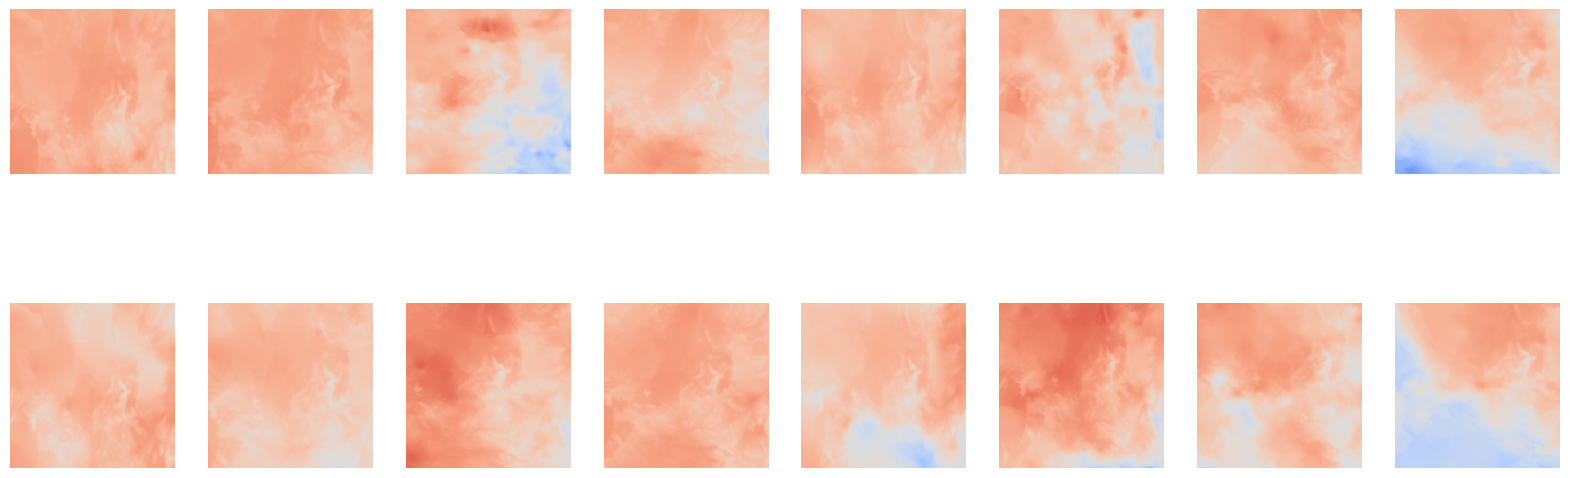

In [16]:
rand_transform = transforms.Compose([
        transforms.RandomResizedCrop(128, scale=(0.5, 1.0)),
        transforms.Normalize(
            params['data']['norm_means'], #'Tmin', 'Tmax',
            params['data']['norm_stds'])
    ])


(unsupervised_loader, unsupervised_sampler) = init_data(
    transform=rand_transform,
    batch_size=8,
    surf_vars=params['data']['surf_vars'],
    static_vars=params['data']['static_vars'],
    lat_lim=params['data']['lat_limit'], lon_lim=params['data']['lon_limit'],
    # dataset_samples=1000
)

images, _ = next(iter(unsupervised_loader))
fig, axes = plt.subplots(2, 8, figsize=(20, 7))

for i in range(8):
    axes[0, i].imshow(images[i][0], cmap='coolwarm',vmin=-6.9798,vmax=4.0726)
    axes[0, i].axis("off")
    axes[1, i].imshow(images[i][1], cmap='coolwarm',vmin= -7.0872,vmax =4.1556)
    axes[1, i].axis("off")

In [4]:
# Create the encoder and load the latest checkpoint

target_encoder = init_model(
    device = "cuda:0",
    model_name = params['meta']['model_name'],
    use_bn = params['meta']['use_bn'],
    hidden_dim = params['meta']['hidden_dim'],
    output_dim = params['meta']['output_dim'],
    drop_path_rate = params['meta']['drop_path_rate'],
)

print(params['logging']['folder'])

latest_checkpoint = os.path.join(params['logging']['folder'], params['logging']['write_tag'] + "-latest.pth.tar")
checkpoint = torch.load(latest_checkpoint, map_location='cpu')

target_encoder.load_state_dict(checkpoint['target_encoder'], strict=False)
target_encoder.eval()

prot = checkpoint['prototypes'].to("cuda:0")
prot = torch.nn.functional.normalize(prot)
prot.shape

INFO:root:VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(2, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (fc): Sequent

/tmp/ipykernel_572223/3250692909.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest_checkpoint, map_location='cpu')


torch.Size([60, 128])

In [17]:
from tqdm import tqdm

# Encode the images with progress bar
E = torch.empty(0, params['meta']['output_dim']).to("cuda:0")
F = torch.empty(0, prot.shape[0]).to("cuda:0")
L = torch.empty(0).to("cuda:0")

with torch.no_grad():
    for img, lab in tqdm(unsupervised_loader.dataset, desc="Encoding"):
        img = img.unsqueeze(0).to("cuda:0")
        enc = target_encoder(img)
        enc = torch.nn.functional.normalize(enc)
        E = torch.cat((E, enc), 0)
        F = torch.cat((F, enc @ prot.T), 0)
        L = torch.cat((L, lab.unsqueeze(0).to("cuda:0")), 0)

print(E.shape, F.shape, L.shape)

Encoding: 100%|██████████| 23090/23090 [02:55<00:00, 131.89it/s]

torch.Size([23090, 128]) torch.Size([23090, 60]) torch.Size([23090])


In [18]:
# Concatenate prototypes and latent points
data = torch.cat((E.cpu(), prot.cpu()), dim=0).numpy()

# Apply TSNE
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(data)

# Separate the results for prototypes and latent points
tsne_E = tsne_results[:E.shape[0]]
tsne_prot = tsne_results[E.shape[0]:]

#F.argmax(axis=1).cpu().numpy() # <- msn assignment
#L.cpu().numpy() # <- ground truth

In [27]:
F.shape

torch.Size([23090, 60])

In [28]:
F.argmax(axis=1).cpu().numpy() # <- msn assignment

array([52, 10, 52, ..., 53, 53, 29])

In [30]:
tsne_prot.shape

(60, 2)

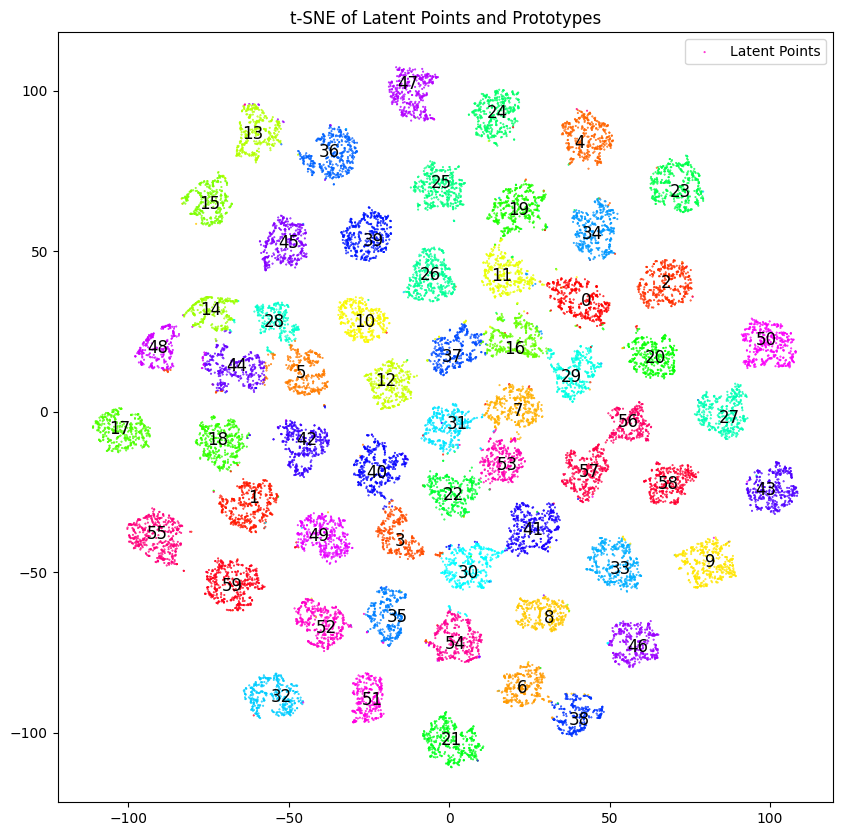

In [31]:
# Plot the TSNE results
cluster_labels = F.argmax(axis=1).cpu().numpy()
plt.figure(figsize=(10, 10))
plt.scatter(tsne_E[:, 0], tsne_E[:, 1], c= cluster_labels, cmap='hsv', label='Latent Points', s=0.2)
# plt.scatter(tsne_prot[:, 0], tsne_prot[:, 1], c='black', label='Prototypes', marker='.')
for i, (x, y) in enumerate(tsne_prot):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center')

plt.legend()
plt.title("t-SNE of Latent Points and Prototypes")
plt.show()

In [57]:
len(F)

23090

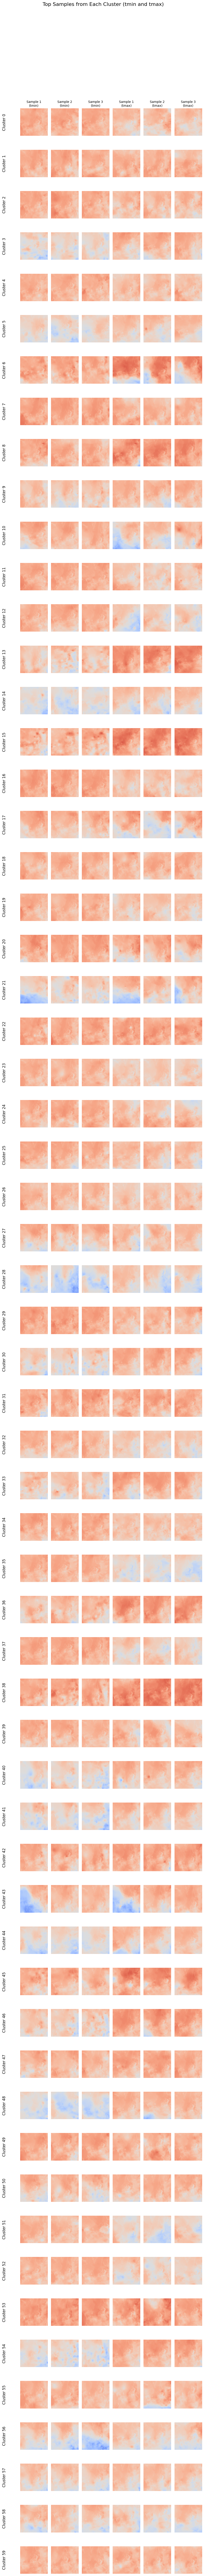

In [55]:
Top = 3

# max_val, max_idx = torch.max(torch.rand(100, params['criterion']['num_proto']), dim=1) # Simula F
max_val, max_idx = torch.max(F, dim=1) # Obtém os valores máximos e seus índices
df = pd.DataFrame({"max_idx": max_idx.cpu(), "max_val": max_val.cpu()})

fig, axes = plt.subplots(params['criterion']['num_proto'], Top * 2, figsize=(Top * 3, params['criterion']['num_proto'] * 2)) # Ajusta o tamanho da figura
fig.suptitle("Top Samples from Each Cluster (tmin and tmax)", fontsize=16) # Título geral da figura

for i in range(params['criterion']['num_proto']):
    top_samples = df[df["max_idx"] == i].nlargest(Top, "max_val")

    for j, im_index in enumerate(top_samples.index):
        image_data = unsupervised_loader.dataset[im_index][0]

        # Plotar dimensão 1 (tmin)
        ax_tmin = axes[i, j]
        ax_tmin.imshow(image_data[0], cmap='coolwarm', vmin=-6.9798, vmax=4.0726)
        ax_tmin.axis("off")
        if i == 0: # Adiciona título da coluna apenas na primeira linha
            ax_tmin.set_title(f"Sample {j+1}\n(tmin)", fontsize=10)

        # Plotar dimensão 2 (tmax)
        ax_tmax = axes[i, j + Top] # Correção do índice para a segunda dimensão
        ax_tmax.imshow(image_data[1], cmap='coolwarm', vmin=-7.0872, vmax=4.1556)
        ax_tmax.axis("off")
        if i == 0: # Adiciona título da coluna apenas na primeira linha
            ax_tmax.set_title(f"Sample {j+1}\n(tmax)", fontsize=10)

    # Adicionar título para cada linha de cluster
    axes[i, 0].text(-0.5, 0.5, f"Cluster {i}", transform=axes[i, 0].transAxes,
                    fontsize=12, va='center', ha='right', rotation=90)


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout para evitar sobreposição, deixando espaço para o título geral
plt.show()

Plot groups distributions according to weather seasons  /patterns

In [ ]:
df.index=pd.to_datetime(unsupervised_loader.dataset.time)
df.head()

max_idx   max_val
1961-01-01       52  0.912607
1961-01-02       10  0.886604
1961-01-03       52  0.927949
1961-01-04       51  0.962296
1961-01-05       52  0.846989

In [78]:
def get_season(date):
    month = date.month
    day = date.day

    # Verão: 21 ou 22 de dezembro a 20 ou 21 de março
    if (month == 12 and day >= 21) or \
       (month == 1 or month == 2) or \
       (month == 3 and day <= 20):
        return 'Verão'
    # Outono: 20 ou 21 de março a 20 ou 21 de junho
    elif (month == 3 and day >= 21) or \
         (month == 4 or month == 5) or \
         (month == 6 and day <= 20):
        return 'Outono'
    # Inverno: 20 ou 21 de junho a 22 ou 23 de setembro
    elif (month == 6 and day >= 21) or \
         (month == 7 or month == 8) or \
         (month == 9 and day <= 22):
        return 'Inverno'
    # Primavera: 22 ou 23 de setembro a 20 ou 21 de dezembro
    else: # (month == 9 and day >= 23) or (month == 10 or month == 11) or (month == 12 and day <= 20)
        return 'Primavera'

# Aplique a função para criar uma nova coluna 'season'
df['season'] = df.index.to_series().apply(get_season)


In [82]:
season_cluster_distribution = pd.crosstab(df['season'], df['max_idx'])

In [83]:
season_cluster_distribution

max_idx     0    1    2    3    4    5    6    7    8    9   ...   50   51  \
season                                                       ...             
Inverno      0    0    0  340    1  204   40    2  108  136  ...   23    0   
Outono      58   83   90   17   71  154    4   62    2  284  ...  407   56   
Primavera  184   62  103    0   73    0  272  143  234   13  ...   13  114   
Verão      161  288  218    0  274    0    7  177    2    5  ...    1  152   

max_idx     52   53   54   55   56   57   58   59  
season                                             
Inverno      0    1  376    2   70   74   34    0  
Outono      41   20    0   81  205  310  264   83  
Primavera   97  172    0   55   10    0   40   98  
Verão      258  139    0  316    5    1   18  266  

[4 rows x 60 columns]

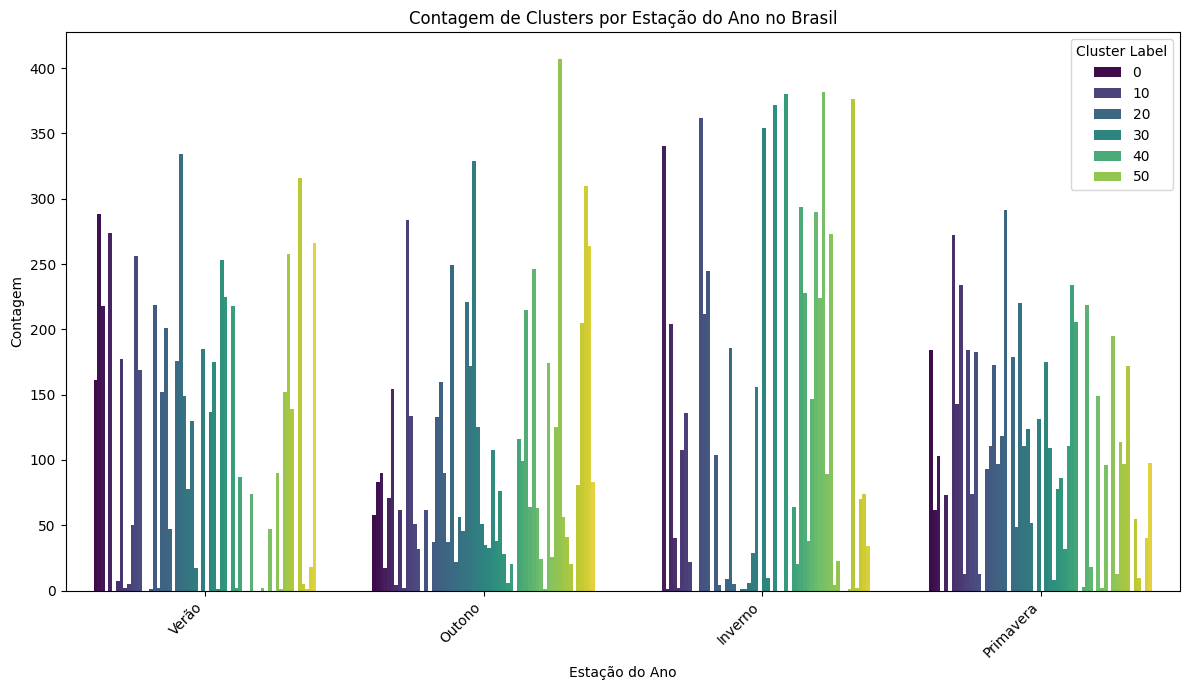

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='season', hue='max_idx', order=season_order, palette='viridis')
plt.title('Contagem de Clusters por Estação do Ano no Brasil')
plt.xlabel('Estação do Ano')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster Label')
plt.tight_layout()
plt.show()


In [178]:
# https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-nino-index
oni_index = pd.read_excel('data/oni_index.xlsx')
oni_index.set_index('Year', inplace=True)
oni_index.columns.name='Month'
oni_index.columns = range(1,13)
oni_index= oni_index.unstack().to_frame('ONI')
oni_index['date_period'] = pd.to_datetime(oni_index.index.map(lambda x: f"{x[1]}-{x[0]}-01")).to_period('M')
oni_index.set_index('date_period', inplace=True)

oni_index =oni_index[oni_index.index.year>=1961]

oni_index.loc[oni_index['ONI'] > 0.5,'Label'] = 'El Niño'
oni_index.loc[oni_index['ONI'] < -0.5,'Label'] = 'La Niña'
oni_index.loc[oni_index['ONI'].between(-0.5, 0.5), 'Label'] = 'Neutro'

In [ ]:
df['period']= df.index.to_period('M')
df = df.merge(oni_index[['Label']], left_on='period', right_index=True, how='left')
df.head()

max_idx   max_val season   period   Label
1961-01-01       52  0.912607  Verão  1961-01  Neutro
1961-01-02       10  0.886604  Verão  1961-01  Neutro
1961-01-03       52  0.927949  Verão  1961-01  Neutro
1961-01-04       51  0.962296  Verão  1961-01  Neutro
1961-01-05       52  0.846989  Verão  1961-01  Neutro

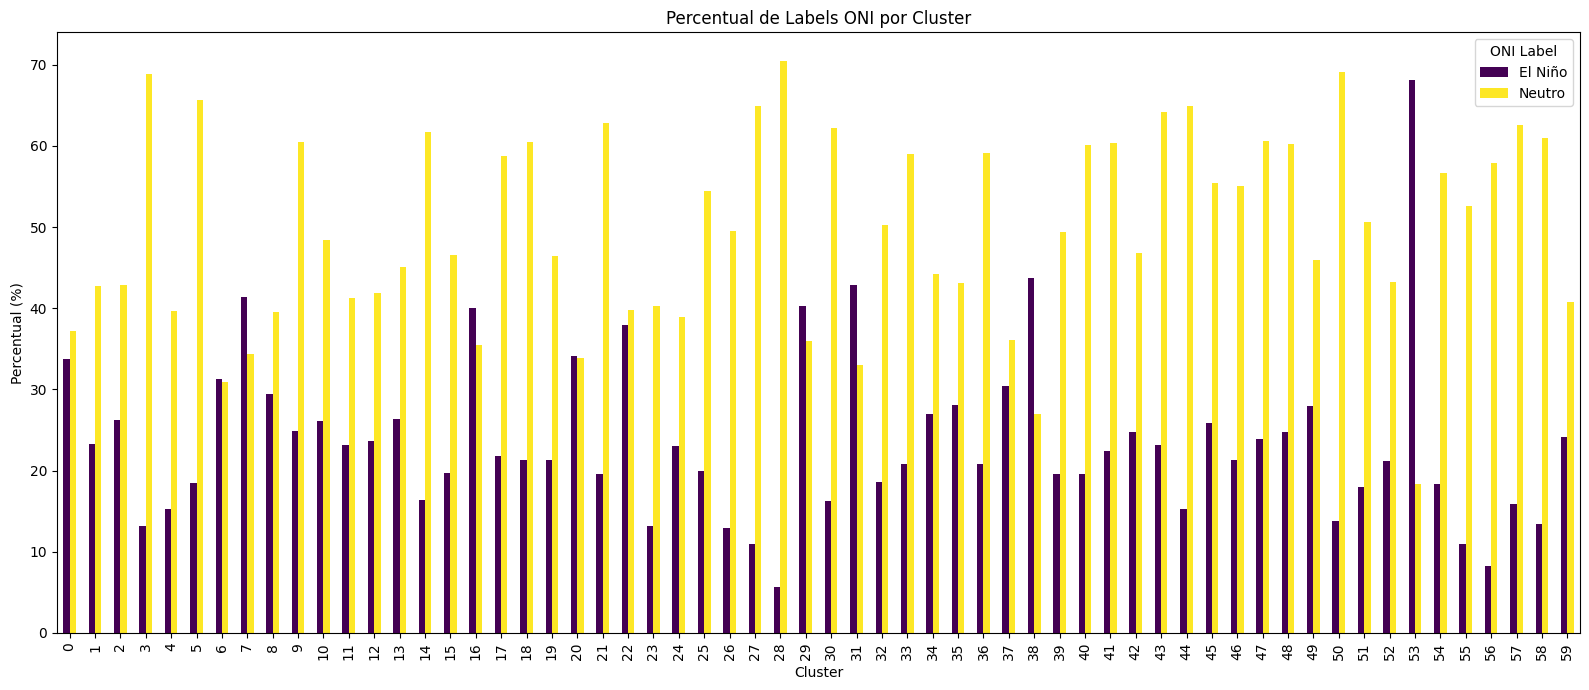

In [212]:
#bar plot 
#max_idx vs Label
# Calculate percentual count for each label within each cluster
percent_df = (
    df.groupby(['max_idx', 'Label'])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
    .droplevel(0)
)



# # Plot
percent_df.drop(columns=['La Niña']).plot(kind='bar', stacked=False, figsize=(16, 7), colormap='viridis')
plt.ylabel('Percentual (%)')
plt.xlabel('Cluster')
plt.title('Percentual de Labels ONI por Cluster')
plt.legend(title='ONI Label')
plt.tight_layout()
plt.show()


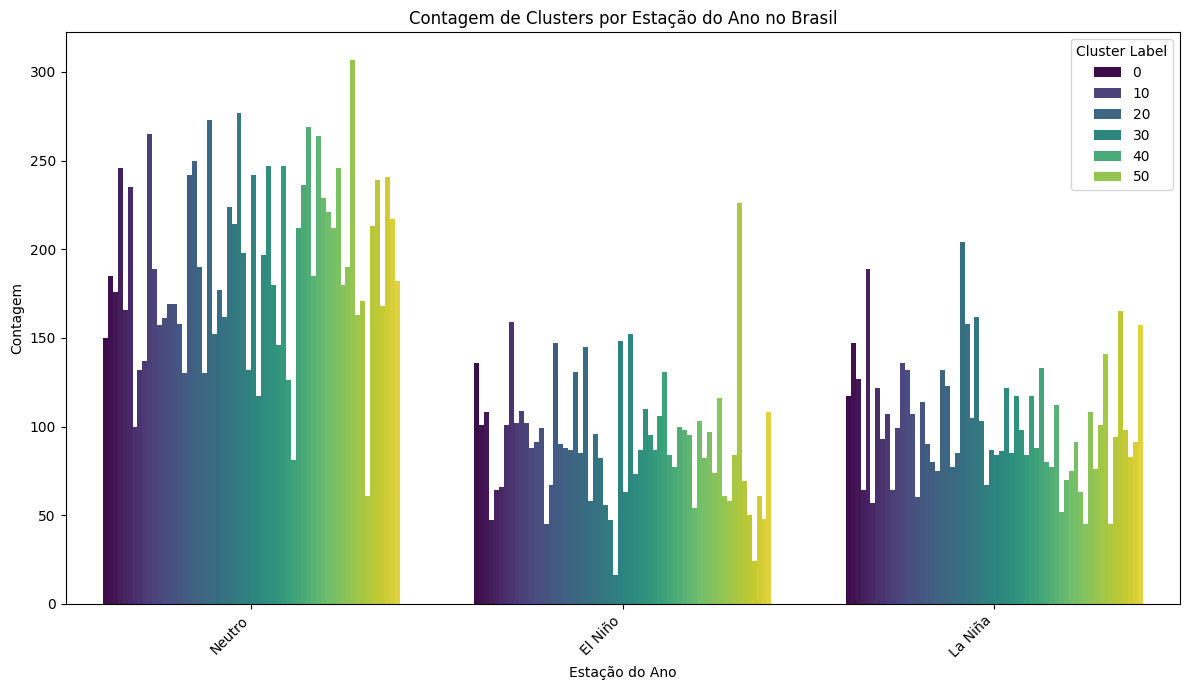

In [189]:

plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='Label', hue='max_idx', palette='viridis')
plt.title('Contagem de Clusters por Estação do Ano no Brasil')
plt.xlabel('Estação do Ano')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster Label')
plt.tight_layout()
plt.show()
